In [62]:
from presto_mod.pulsed import pulse_test as pt
from presto_mod.pulsed import pulsed_test_with_probe as ptpr
from presto_mod.pulsed import PhotonSplitting as PS
from presto_mod.pulsed import PhotonSplitting_4ports as PS4

import matplotlib.patches as patches
import time
import numpy as np
import scipy.io as sio

from scipy.io import savemat
from scipy.io import loadmat

import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
import time
import pyvisa


import os
Global_data_adress = r"E:\Data\2025\SNAILJPA\Coupler_May\JPA_photomultiplier"
exp_name = 'Phase_sweep'
file_folder = Global_data_adress+'\\'+exp_name
if not os.path.exists(file_folder):
  os.mkdir(file_folder)
  print("Folder %s created!" % file_folder)
else:
  print("Folder %s already exists" % file_folder)

presto_address = "169.254.3.14"  # your Presto IP address

Folder E:\Data\2025\SNAILJPA\Coupler_May\JPA_photomultiplier\Phase_sweep created!


In [63]:
def cut_h(f, f0, f1):
    return np.heaviside(f - f0, 1) - np.heaviside(f - f1, 1)

def low_pass(signal, dt, f0, f1):
    fft_signal = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(signal), d=dt)
    window = cut_h(np.abs(freqs), f0, f1)
    return np.fft.ifft(fft_signal * window)  # Return the filtered FFT

# def hann_window(freqs, f0, f1):
#     """
#     Smooth Hann window between f0 and f1.
#     """
#     window = np.zeros_like(freqs)
#     band = (freqs >= f0) & (freqs <= f1)
#     if np.any(band):
#         n = np.sum(band)
#         hann = 0.5 - 0.5 * np.cos(2 * np.pi * np.linspace(0, 1, n))
#         window[band] = hann
#     return window

# def low_pass_hann_complex(matrix, dt, f0, f1):
#     """
#     Low-pass filter for a complex NxM signal along axis=1 using Hann window.

#     Parameters:
#         matrix (np.ndarray): Input (N x M) complex matrix.
#         dt (float): Time interval along columns (axis=1).
#         f0, f1 (float): Frequency band to pass [f0, f1].

#     Returns:
#         np.ndarray: Complex filtered signal (N x M).
#     """
#     N, M = matrix.shape
#     freqs = np.fft.fftfreq(M, d=dt)  # shape: (M,)

#     # Create Hann window in frequency domain (shape: (1, M))
#     window = hann_window(np.abs(freqs), f0, f1).reshape(1, M)

#     # FFT along axis=1 (columns)
#     fft_matrix = np.fft.fft(matrix, axis=1)

#     # Apply filter window
#     filtered_fft = fft_matrix * window  # broadcasted

#     # Inverse FFT to return filtered signal
#     return np.fft.ifft(filtered_fft, axis=1)


In [64]:
def hann(idx): 
    return np.hanning(len(idx))
    
def cut_h(f, fft_signal, f0, f1):
    # changing array order
    sort_idx = np.argsort(f)
    sorted_arr = f[sort_idx]
    sorted_arr_fft = fft_signal[sort_idx]
    original_idx = np.argsort(sort_idx)

    cut_range = np.heaviside(sorted_arr - f0, 1) - np.heaviside(sorted_arr - f1, 1)
    idx = np.where(cut_range!=0)[0]
    hann_f = hann(idx)
    for i in range(len(cut_range)):
        if i <= idx[-1] and i>=idx[0]:
            cut_range[i] = cut_range[i]*hann_f[i-idx[0]]

    return (sorted_arr_fft*cut_range)[original_idx]

def low_pass(signal, dt, f0, f1):

    if len(signal.shape)==1:
    
        fft_signal = np.fft.fft(signal)
        freqs = np.fft.fftfreq(len(signal), d=dt)
        fig, ax = plt.subplots()
        ax.plot(freqs, fft_signal)
        
        window = cut_h(freqs, fft_signal, f0, f1)
        cut_signal = np.fft.ifft(window)
    else: 
        cut_signal = np.zeros((len(signal), len(signal[0])))*1j
        for i in range(len(signal)):
            mini_signal = signal[i]

            fft_signal = np.fft.fft(mini_signal)
            freqs = np.fft.fftfreq(len(mini_signal), d=dt)
            
            window = cut_h(freqs, fft_signal, f0, f1)
            cut_signal[i] = np.fft.ifft(window)
            
    return  cut_signal # Return the filtered FFT

signal = np.array([np.random.rand(500,500)])

# plt.plot(np.fft.fftshift(np.fft.fft(signal[0,0,:])))
# a = low_pass(signal[0,:,:], 1e-9, -2e8, 2e8)
# plt.plot(np.fft.fftshift(np.fft.fft(a[0,:])))

In [240]:
print(datetime.now())

omega2 = 5.854317e9*2
if_freq  = 3.6e9
lo_freq = omega2-if_freq
hc_freq = 5.854317e9
# if_freq  = omega2/2
Readout_freq = omega2/2

lo_freq = omega2*3/4
if_freq  = lo_freq-omega2/2


print("LO frequency:", lo_freq)
print("IF frequency:", if_freq)
print("Readout frequency:", Readout_freq)

Readout_phase = np.pi*0
HC_phase = 0

Downsampling = 2
pulse_repeats = 1

delay = 200e-9
LO_duration=600e-9
IF_duration= 16e-9
PR_duration = 16e-9
HC_duration = 0e9

readout_delay = 8*92e-9
print('Readout delay:', readout_delay*1e9)
Readout_duration = (PR_duration+delay*2)*pulse_repeats
wait_delay = (readout_delay+Readout_duration)*5
pulse_delay = 200e-9

LO_amp = 0.8
IF_amp = 0.8
PR_amp = 0.8
HC_amp = 0
Probe_phase = 0.1*np.pi/2

num_repeats = 1 # 400000
num_averages = 10000000 


experiment = PS.PhotonSplitting(
        LO_port=1, # LO
        IF_port=9, # IF
        PR_port=6,  # 6: JPA in, 7: HC, 8: Pump 
        HC_port=7,  # 6: JPA in, 7: HC, 8: Pump 
        readout_port1=7,  # TWPA 1
        readout_port2=6,  # TWPA 2
        file_folder = file_folder,
        file_name = 'phase_sweep',
        
        LO_freq=lo_freq,
        LO_amp=LO_amp,
        LO_duration=LO_duration,
        
        IF_freq=if_freq,
        IF_amp = IF_amp,
        IF_duration=IF_duration,       

        PR_freq = Readout_freq,
        PR_amp = PR_amp,
        PR_duration = PR_duration, 
        probe_phase=Probe_phase,

        HC_freq = hc_freq,
        HC_amp = HC_amp,
        HC_duration = HC_duration,
        HC_phase = HC_phase,

        readout_freq=Readout_freq,
        readout_phase=Readout_phase,
        downsampling=Downsampling,
        
        readout_duration=Readout_duration,
        delay=delay,
        
        wait_delay=wait_delay,
        readout_delay=readout_delay,

        pulse_repeats = pulse_repeats,
        num_repeats=num_repeats, 
        num_averages=num_averages,
        # envelope_function = sin2, 

        sampling_avg = 1,
    )

2025-05-12 11:24:30.000550
LO frequency: 8781475500.0
IF frequency: 2927158500.0
Readout frequency: 5854317000.0


# Test pulse propogation

In [241]:
att_list = experiment.run(presto_address)
data = att_list['data']
TWPA1 = data[:,0,:]
TWPA2 = data[:,1,:]
print(TWPA1.shape)

KeyboardInterrupt: 

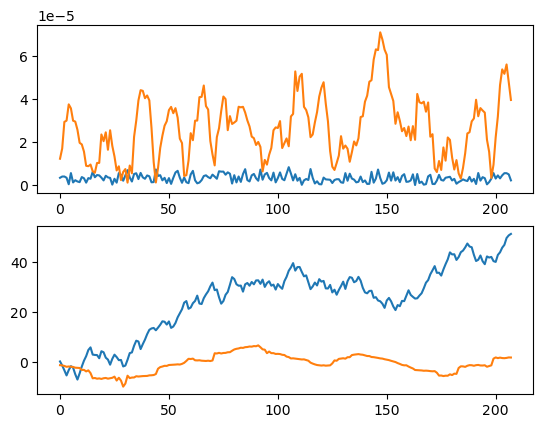

In [230]:
fig, ax = plt.subplots(2, 1)
start_i = 50
stop_i = 140
ax[0].plot(np.abs(np.mean(TWPA1[:,:],axis=0)))
ax[0].plot(np.abs(np.mean(TWPA2[:,:],axis=0)))

# ji = 101
# ax[0].plot(np.abs(TWPA1[ji,:]))
# ax[0].plot(np.abs(TWPA2[ji,:]))

# ax[0].plot(np.abs(np.mean(TWPA1[:,start_i:stop_i],axis=0)))

ax[1].plot(np.unwrap(np.angle(np.mean(TWPA1[:,:],axis=0))))
ax[1].plot(np.unwrap(np.angle(np.mean(TWPA2[:,:],axis=0))))

# Phase sweep

In [242]:
timestart = datetime.now()
print(timestart)

excluded_attrs = {"LO_envelope_function", "IF_envelope_function", "PR_envelope_function", "data"}  # Set of attributes to exclude

Probe_phas = np.linspace(0, 2*np.pi, 51)
Repeats = np.ones(1)

for i in range(len(Probe_phas)):
    experiment.probe_phase = Probe_phas[i]
    for j in range(len(Repeats)):
        
        att_list = experiment.run(presto_address)
        data = att_list['data']
        TWPA1 = data[:,0,:]
        TWPA2 = data[:,1,:]

        attributes_list = [
            (attr, value) for attr, value in experiment.__dict__.items() if attr not in excluded_attrs
        ]
        
        sio.savemat(str(file_folder) + '\\JPA_PM_Phase_sweep_' + str(i) + '_' + str(j) + datetime.now().strftime(r'--%Y.%m.%d')  + '.mat', 
                    {'TWPA1': TWPA1, 'TWPA2': TWPA2, 'Probe_phas': Probe_phas, 'Current_pha': Probe_phas[i], 'attributes_list': attributes_list})

timestop = datetime.now()
print(timestop-timestart)

2025-05-12 11:24:34.677894
Run finishedted at 2025-05-12 11:24:34.682724
Run finishedted at 2025-05-12 11:25:14.098908
Run finishedted at 2025-05-12 11:25:53.501835
Run finishedted at 2025-05-12 11:26:32.973542
Run finishedted at 2025-05-12 11:27:12.359796
Run finishedted at 2025-05-12 11:27:51.758482
Run finishedted at 2025-05-12 11:28:31.171786
Run finishedted at 2025-05-12 11:29:10.582026
Run finishedted at 2025-05-12 11:29:50.066760
Run finishedted at 2025-05-12 11:30:29.444815
Run finishedted at 2025-05-12 11:31:08.916030
Run finishedted at 2025-05-12 11:31:48.370898
Run finishedted at 2025-05-12 11:32:27.824452
Run finishedted at 2025-05-12 11:33:07.206995


KeyboardInterrupt: 

In [123]:
TWPA1.shape

(1, 240)